# SOADML - Incremental methods with second order information

    Authors : Léa Bresson, Charles Dognin
   
The aim of this notebook is to implement and compare the algorithms introduced in 2018 by Gower et al. in the paper "**Tracking the gradients using the Hessian : A new look at variance reducing stochastic methods**". We discuss the efficiency of the algorithms proposed in this paper by benchmarking it against SVRG on classification and regression problems. 

The following methods are compared :  **a verif**
- the original Stochastic Variance Reduced Gradient (*SVRG*) algorithm,
- *SVRG2*, which tracks the gradients using the full Hessian,
- *2D*, which tracks the gradients using the diagonal of the Hessian,
- *2Dsec*, which tracks the gradients using the robust secant equation,
- *CM*, which tracks the gradients using the low-rank curvature matching approximation of the Hessian,
- *AM*, which uses the low-rank action matching approximation of the Hessian. 

First, we consider a **logistic regression** with ridge penalization using the same dataset as the authors, i.e. the *Gisette* dataset. Then, we consider a **least-squares regression** with ridge penalization (not implemented by Gower et al.) using the *Cadata* dataset from LIBSVM.

### Table of content
[1. Loss functions and gradients for logistic regression (Gisette dataset)](#dataclassif)<br>
[2. Loss functions and gradients for least-squares regression (Cadata dataset)](#datareg)<br>
[3. Algorithms](#algo)<br>
[4. Classification case : Numerical comparison](#comp1)<br>
[5. Regression case : Numerical comparison](#comp2)<br>
[6. Conclusions](#conc)<br>




In [1]:
%matplotlib inline

In [51]:
# Package Imports 

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
#from numba import njit
from scipy.linalg import norm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_svmlight_file, load_diabetes
from scipy.linalg import svd
from scipy.optimize import fmin_l_bfgs_b
import scipy
import time

<a id='dataclassif'></a>
## 1. Loss functions and gradients for logistic regression (Gisette dataset)


### Gisette Dataset Pre-Processing

Gisette is a handwritten digit recognition problem inspired by the MINST dataset. The problem is to separate the highly confusable digits '4' and '9'. This is a binary classification problem. The dataset contains 5000 features and 6000 samples.

In [3]:
def preprocessing_y(filename):
    data = []
    with open(filename) as file:
        for row in file.readlines():
            data.append((row.strip()).split(" "))
    data = np.array(data).astype(int)
    data = np.squeeze(data, axis=1)
    return data

def preprocessing_x(filename):
    data = []
    with open(filename) as file:
        for row in file.readlines():
            data.append((row.strip()).split(" "))
    data = np.array(data).astype(int)
    return data

# Here the shape of x_train is (6000, 5000) = (number of examples, dimension)
x_train_c = preprocessing_x("gisette_train.data")
x_train_c = x_train_c
y_train_c = preprocessing_y("gisette_train.labels")
y_train_c = y_train_c


# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
x_train_c = scaler.fit_transform(x_train_c)
pca = PCA(n_components=300)
x_train_c = pca.fit_transform(x_train_c)


/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Logistic loss with a squared-$ \ell$2 regularizer

We want to minimize
$$
\frac 1n \sum_{i=1}^n \log(1 + \exp(-y_i X_i^\top \theta)) + \frac \lambda 2 \|\theta\|_2^2  = \frac 1n \sum_{i=1}^n f_i(\theta)
$$

where
$$
f_i(\theta) = \log(1 + \exp(-y_i X_i^\top \theta) + \frac \lambda 2 \|\theta\|_2^2.
$$

The gradient is 
$$
\nabla f_i(\theta) = - \frac{y_i}{1 + \exp(y_i X_i^\top \theta)} X_i + \lambda \theta.
$$


The Hessian is 


### Parameter values

#### Stepsize
The stepsize used by Gower et al. is $ \frac{2^a}{\max_{i=1,\ldots,n} L_i}$ where $L_i$ the Lipschitz constant of $f_i$ . The value of $a$ is chosen through a grid search procedure for $a = 10,7...,-7,-9$. 

For logistic regression, using $\|\cdot\|_{2}$ for the matrix spectrale norm, we have: $L_i = \frac 14 \| X_i \|_2^2 + \lambda$.


#### Regularization parameter

We use the same regularization parameter as Gower et al.: $ \lambda= max_{i=1,…,n} \frac{||X_i||_2^2}{ 4n}$.

In [4]:
# We define the functions used in the optimization part 

class Classification(object):
    """A class for the logistic regression with ridge penalization"""
    
    def __init__(self, x_train, y_train, lbda):
        self.x_train = x_train
        self.y_train = y_train
        self.n, self.d = x_train.shape
        self.lbda = lbda
        self.sigma = np.sqrt(0.1)

    def loss(self, theta):
        bAx = self.y_train * np.dot(self.x_train, theta)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * np.linalg.norm(theta) ** 2 / 2.

    def grad(self, theta):
        bAx = self.y_train * np.dot(self.x_train, theta)
        temp = 1. / (1. + np.exp(bAx))
        grad = - np.dot(self.x_train.T, self.y_train * temp) / self.n + self.lbda * theta
        return grad
    
    def grad_i(self, i, theta):
        grad = - self.x_train[i] * self.y_train[i] / (1. + np.exp(self.y_train[i] * np.dot(self.x_train[i], theta)))
        grad += self.lbda * theta
        return grad
            
    def hess(self, theta):
        D = np.exp(self.y_train * np.dot(self.x_train, theta)) / (1 + np.exp(self.y_train * np.dot(self.x_train, theta))**2)
        D = np.diag(D)
        hess = self.x_train.T.dot(D.dot(self.x_train)) / n + self.lbda
        #hess = np.mean([self.hess_i(i, theta) for i in range(self.n)], axis=0)
        return hess
        
    def hess_i(self, i, theta):
        temp = np.exp(self.y_train[i] * np.dot(self.x_train[i], theta)) / ((1. + np.exp(self.y_train[i] * np.dot(self.x_train[i], theta))) ** 2)
        xy = self.x_train[i] * self.y_train[i] 
        xy = np.expand_dims(xy, axis=1)
        hess = np.dot(xy, xy.T) * temp + self.lbda
        return hess 
    
    def hess_i_diag(self, i, theta, theta_bar):
        a = (theta - theta_bar) * (self.grad_i(i, theta) - self.grad_i(i, theta_bar)) + (self.sigma ** 2) * np.diag(np.diag(self.hess_i(i, theta_bar)))
        b = (theta - theta_bar) * (theta - theta_bar) + self.sigma ** 2
        return a / b
    
    def lipschitz_constant(self):
        return np.linalg.norm(self.x_train, ord=2) ** 2 / (4. * self.n) + self.lbda  

### Get a very precise minimum to compute distances to minimum

Gower et al. use the relative suboptimality gap to assess the efficiency of the proposed algorithms: $$\frac{f(\theta)-f(\theta^*)}{f(\theta_0) - f(\theta^*)}$$

To compute the relative suboptimality gap, we assume that $ \theta^*$ is given by the ``scipy.optimize``'s BFGS solver.

In [5]:
n,d = x_train_c.shape
x_init_c = np.zeros(d)
lbda = np.max(np.sum(x_train_c**2, axis=1)) / (4.*n)

model = Classification(x_train_c, y_train_c, lbda)
x_min_c, f_min_c, _ = fmin_l_bfgs_b(model.loss, x_init_c, model.grad, pgtol=1e-30, factr=1e-30)

print("The min of the loss is" , f_min_c)

The min of the loss is 0.32300864484638203


<a id='datareg'></a>
## 2. Loss functions and gradients for least-squares regression (Cadata dataset)


### Cadata Dataset Pre-Processing

The California housing dataset (Cadata) contains details related to the housing of the population in a given California district (number of people in a certain area, geographic area, average income, housing average age, average rooms, etc.). The average house value is the target variable.
The dataset contains 8 features and 20640 samples.

In [6]:
x_train , y_train = load_svmlight_file("cadata.txt")

# Here the shape of x_train is (20640, 8) = (dimension, number of examples)
x_train = x_train.toarray()
y_train = y_train.reshape((y_train.size, 1))
print(x_train.shape)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
x_train_r = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train)
y_train_r = y_train.reshape((y_train.size,))

(20640, 8)


### Least-squares loss with a squared-$ \ell$2 regularizer

We want to minimize
$$
\frac 1n \sum_{i=1}^n \frac 12 (y_i - X_i^\top \theta)^2 + \frac \lambda 2 \|\theta\|_2^2 = \frac 1n \sum_{i=1}^n f_i(\theta)
$$

where
$$
f_i(\theta) = \frac 12 (y_i - X_i^\top \theta)^2  + \frac \lambda 2 \|\theta\|_2^2.
$$

The gradient is
$$
\nabla f_i(\theta) = (X_i^\top \theta - y_i) X_i + \lambda \theta
$$

The hessian is
$$
H_i(\theta) = X_i {X_i}^{T} + \lambda I
$$


### Parameter values

#### Stepsize
The stepsize used is $ \frac{2^a}{\max_{i=1,\ldots,n} L_i}$ where $L_i$ the Lipschitz constant of $f_i$ and $a = 2^4$. **à verif // à voir + tard The value of $a$ is chosen through a grid search procedure for $a=10,7...,−7,−9$. **

For least-squares regression, using $\|\cdot\|_{2}$ for the matrix spectrale norm, we have: $L_i = \| X_i \|_2^2 + \lambda$.


#### Regularization parameter

The regularization parameter is set to $ \lambda= max_{i=1,…,n} \frac{||X_i||_2^2}{n}$..

In [7]:
# We define the functions used in the optimization part 

class Regression(object):
    """A class for the least-squares regression with ridge penalization"""

    def __init__(self, x_train, y_train, lbda):
        self.x_train = x_train
        self.y_train = y_train
        self.n, self.d = x_train.shape
        self.lbda = lbda
        self.sigma = np.sqrt(0.1)

    def grad(self, theta):
        return self.x_train.T.dot(self.x_train.dot(theta) - self.y_train) / self.n + self.lbda * theta

    def loss(self, theta):
        return norm(self.x_train.dot(theta) - self.y_train) ** 2 / (2. * self.n) + self.lbda * norm(theta) ** 2 / 2.

    def grad_i(self, i, theta):
        a_i = self.x_train[i]
        return (a_i.dot(theta) - self.y_train[i]) * a_i + self.lbda * theta
    
    def hess(self, theta=None): 
        hess = np.dot(self.x_train.T, self.x_train) / self.n + self.lbda
        return hess 
    
    def hess_i(self, i, theta=None):
        a_i = self.x_train[i]
        a_i = np.expand_dims(a_i, axis=1)
        hess = np.dot(a_i, a_i.T) + self.lbda
        return hess
    
    def hess_i_diag(self, i, theta, theta_bar):
        a = (theta - theta_bar) * (self.grad_i(i, theta) - self.grad_i(i, theta_bar)) + (self.sigma ** 2) * np.diag(np.diag(self.hess_i(i, theta_bar)))
        b = (theta - theta_bar) * (theta - theta_bar) + self.sigma ** 2
        return a / b
        
    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        return norm(self.x_train, ord=2) ** 2 / self.n + self.lbda

### Get a very precise minimum to compute distances to minimum

To compute the relative suboptimality gap, we assume that $ \theta^*$ is given by the ``scipy.optimize``'s BFGS solver.

In [8]:
n,d = x_train_r.shape
x_init_r = np.zeros(d)
lbda = np.max(np.sum(x_train_r**2, axis=1))  / n

model = Regression(x_train_r, y_train_r, lbda)
x_min_r, f_min_r, _ = fmin_l_bfgs_b(model.loss, x_init_r, model.grad, pgtol=1e-30, factr=1e-30)

print("The min of the loss is" , f_min_r)

The min of the loss is 0.22100996724158628


<a id='algo'></a>
## 3. Algorithms



**Number of iterations :** 

According to Johnson and Zhang (in "*Accelerating Stochastic Gradient Descent using predictive Variance Reduction*") ``itr2`` must be the same order of $n$. Concerning ``itr1``, we arbitrary set it to 100.


## SVRG

In [9]:
def optimize_svrg(itr1, itr2, x_train, y_train, stepsize, theta_min=[], f_min=[], verbose=True):
    """Stochastic variance reduction gradient algorithm.

    Output
    ----------
    theta_bar : np.ndarray, shape=(d,)
                The final theta vector found by the algorithm   
        
    errors: list
            Sequence of errors || theta - theta_min || of the algorithm
            
    relative_objectives: list
            Sequence of relative suboptimality gap [f(theta) - f(theta_min)] / [f(theta_0) - f(theta_min)] of the algorithm
            
    grad_norm: list
             Sequence of gradient norms calculated during the iterations of the algorithm
    
    timing: list
             Sequence of time taken during the iterations of the algorithm
    
    """  
    
    # Initialization
    n,d = x_train.shape
    theta_init = np.zeros(d)
    theta_bar = theta_init.copy()
    
    # History 
    grad_norm = []
    errors = [] 
    relative_objectives = []
    t0 = time.time()
    timing = []

    grad_norm.append(np.linalg.norm(model.grad(theta_bar)))
    err = norm(theta_bar - theta_min) #/ norm(theta_min) #a voir 
    errors.append(err)
    obj = model.loss(theta_bar) - f_min
    relative = model.loss(theta_init) - f_min    
    relative_objectives.append(obj/relative)
    tim = time.time()-t0
    timing.append(tim)

    
    # Algorithm  
    for k in range(1, itr1+1):
        grad_k =  model.grad(theta_bar)
        theta = theta_bar.copy()
        
        for t in range(itr2): 
            i = np.random.randint(0, n) 
            theta = theta - stepsize * (model.grad_i(i, theta) - model.grad_i(i, theta_bar) + grad_k)  
            
        theta_bar = theta
        
        obj = model.loss(theta_bar) - f_min
        robj = obj/relative
        err = norm(theta_bar - theta_min) 
        errors.append(err)
        relative_objectives.append(robj)
        grad_norm.append(np.linalg.norm(model.grad(theta_bar)))
        tim = time.time()-t0
        timing.append(tim)
        
        if verbose:
            if k == 1:
                print("Lauching SVRG solver...")
                print(' | '.join([name.center(10) for name in ["it", "err", "subopt_gap", "time", "loss"]]))
            if (k % 10) == 0:
                print(' | '.join([("%d" % k).rjust(10), ("%.4e" % err).rjust(10), ("%.4e" % robj).rjust(10), ("%.4e" % tim).rjust(10), ("%.4e" % model.loss(theta_bar)).rjust(10)]))
            
            
    return theta_bar, np.array(errors), np.array(relative_objectives), grad_norm, np.array(timing)

### Test 

In [10]:
print("\033[1m SVRG - Classification (Gisette Dataset): \033[0m")

n = x_train_c.shape[0]
lbda = np.max(np.sum(x_train_c ** 2, axis=1))  / (4. * n)

model = Classification(x_train_c, y_train_c, lbda)
max_squared_sum = np.max(np.sum(x_train_c ** 2, axis=1)) 
stepsize = 2**5 / (max_squared_sum + lbda) # 2^4 ou 2^5 <= à voir

svrg_theta_c, svrg_err_c, svrg_robj_c, svrg_grad_norm_c, svrg_time_c = optimize_svrg(100, n, x_train_c, y_train_c, stepsize, x_min_c, f_min_c)

 SVRG - Classification (Gisette Dataset): 
Lauching SVRG solver...
    it     |    err     | subopt_gap |    time    |    loss   
        10 | 2.5503e-05 | 4.2444e-09 | 2.2855e+00 | 3.2301e-01
        20 | 3.9107e-08 | 9.8983e-15 | 4.5275e+00 | 3.2301e-01
        30 | 1.4641e-09 | -1.4997e-16 | 6.7287e+00 | 3.2301e-01
        40 | 1.4632e-09 | 0.0000e+00 | 8.9446e+00 | 3.2301e-01
        50 | 1.4632e-09 | -1.4997e-16 | 1.1235e+01 | 3.2301e-01
        60 | 1.4632e-09 | -1.4997e-16 | 1.3564e+01 | 3.2301e-01
        70 | 1.4632e-09 | -1.4997e-16 | 1.5794e+01 | 3.2301e-01
        80 | 1.4632e-09 | -1.4997e-16 | 1.7997e+01 | 3.2301e-01
        90 | 1.4632e-09 | -1.4997e-16 | 2.0242e+01 | 3.2301e-01
       100 | 1.4632e-09 | -1.4997e-16 | 2.2470e+01 | 3.2301e-01


In [11]:
print("\033[1mRegression (Cadata Dataset): \033[0m")
print("")

n = x_train_r.shape[0]
lbda = np.max(np.sum(x_train_r ** 2, axis=1))  / n

model = Regression(x_train_r, y_train_r, lbda)
max_squared_sum = np.max(np.sum(x_train_r ** 2, axis=1)) 
stepsize = 2**5 / (max_squared_sum + lbda) # 2^4 ou 2^5 <= à voir

svrg_theta_r, svrg_err_r, svrg_robj_r, svrg_grad_norm_r, svrg_time_r = optimize_svrg(100, n, x_train_r, y_train_r, stepsize, x_min_r, f_min_r)

Regression (Cadata Dataset): 

Lauching SVRG solver...
    it     |    err     | subopt_gap |    time    |    loss   
        10 | 5.0296e-02 | 1.0995e-02 | 2.9889e+00 | 2.2408e-01
        20 | 2.2967e-04 | 2.8413e-07 | 5.8268e+00 | 2.2101e-01
        30 | 1.4218e-07 | 1.4326e-14 | 8.7371e+00 | 2.2101e-01
        40 | 6.0216e-08 | 2.7856e-15 | 1.1532e+01 | 2.2101e-01
        50 | 5.1286e-09 | 0.0000e+00 | 1.4344e+01 | 2.2101e-01
        60 | 3.8095e-08 | 4.5764e-15 | 1.7343e+01 | 2.2101e-01
        70 | 5.5663e-09 | 1.9897e-16 | 2.0145e+01 | 2.2101e-01
        80 | 5.8987e-09 | 9.9486e-17 | 2.3080e+01 | 2.2101e-01
        90 | 5.8969e-09 | 1.9897e-16 | 2.6041e+01 | 2.2101e-01
       100 | 5.8970e-09 | 2.9846e-16 | 2.8926e+01 | 2.2101e-01


## SVRG2

In [12]:
def optimize_svrg_2(itr1, itr2, x_train, y_train, stepsize, theta_min=[], f_min=[], verbose=True):
    """"Stochastic variance reduction gradient algorithm with second-order tracking.

    Output
    ----------
    theta_bar : np.ndarray, shape=(d,)
                The final x vector found by the algorithm   
        
    errors: list
            Sequence of errors || x - x_min || of the algorithm
            
    relative_objectives: list
            Sequence of relative suboptimality gap [f(x) - f(x_min)] / [f(x_0) - f(x_min)] of the algorithm
            
    grad_norm: list
             Sequence of gradient norms calculated during the iterations of the algorithm
    
    timing: list
             Sequence of time taken during the iterations of the algorithm
    
    """  
    
    # Initialization
    n,d = x_train.shape
    theta_init = np.zeros(d)
    theta_bar = theta_init.copy()
    
    # History 
    grad_norm = []
    errors = [] 
    relative_objectives = []
    t0 = time.time()
    timing = []

    grad_norm.append(np.linalg.norm(model.grad(theta_bar)))
    err = norm(theta_bar - theta_min) #/ norm(theta_min) #
    errors.append(err)
    obj = model.loss(theta_bar) - f_min
    relative = model.loss(theta_init) - f_min    
    relative_objectives.append(obj / relative)
    tim = time.time() - t0
    timing.append(tim)
    
    for k in range(1, itr1+1):
        grad_k =  model.grad(theta_bar)
        hess_k = model.hess(theta_bar)
        theta = theta_bar.copy()
        
        for t in range(itr2):
            i = np.random.randint(0, n)
            
            theta = theta - stepsize * (model.grad_i(i, theta) - model.grad_i(i, theta_bar)
                                        - np.dot(model.hess_i(i, theta_bar), theta - theta_bar)
                                        + grad_k + np.dot(hess_k, theta - theta_bar))
        theta_bar = theta
    
        obj = model.loss(theta_bar) - f_min
        robj = obj/relative
        err = norm(theta_bar - theta_min) 
        errors.append(err)
        relative_objectives.append(robj)
        grad_norm.append(np.linalg.norm(model.grad(theta_bar)))
        tim = time.time() - t0
        timing.append(tim)
        
        if verbose:
            if k == 1:
                print("Lauching SVRG2 solver...")
                print(' | '.join([name.center(10) for name in ["it", "err", "subopt_gap", "time", "loss"]]))
            if (k % 10) == 0:
                print(' | '.join([("%d" % k).rjust(10), ("%.4e" % err).rjust(10), ("%.4e" % robj).rjust(10), ("%.4e" % tim).rjust(10), ("%.4e" % model.loss(theta_bar)).rjust(10)]))
            
            
    return theta_bar, np.array(errors), np.array(relative_objectives), grad_norm, np.array(timing)

### Test 

In [13]:
print("\033[1m SVRG2 - Classification (Gisette Dataset): \033[0m")

n = x_train_c.shape[0]
lbda = np.max(np.sum(x_train_c ** 2, axis=1))  / (4. * n)

model = Classification(x_train_c, y_train_c, lbda)
max_squared_sum = np.max(np.sum(x_train_c ** 2, axis=1)) 
stepsize = 2**5 / (max_squared_sum + lbda) # 2^4 ou 2^5 <= à voir

svrg2_theta_c, svrg2_err_c, svrg2_robj_c, svrg2_grad_norm_c, svrg2_time_c = optimize_svrg_2(100, n, x_train_c, y_train_c, stepsize, x_min_c, f_min_c)

 SVRG2 - Classification (Gisette Dataset): 
Lauching SVRG2 solver...
    it     |    err     | subopt_gap |    time    |    loss   
        10 | 1.8995e-06 | 6.5809e-11 | 1.8602e+01 | 3.2301e-01
        20 | 1.4696e-09 | -1.4997e-16 | 3.7185e+01 | 3.2301e-01
        30 | 1.4632e-09 | -1.4997e-16 | 5.5850e+01 | 3.2301e-01
        40 | 1.4632e-09 | 0.0000e+00 | 7.4512e+01 | 3.2301e-01
        50 | 1.4632e-09 | 0.0000e+00 | 9.3311e+01 | 3.2301e-01
        60 | 1.4632e-09 | 0.0000e+00 | 1.1205e+02 | 3.2301e-01
        70 | 1.4632e-09 | 0.0000e+00 | 1.3068e+02 | 3.2301e-01
        80 | 1.4632e-09 | 0.0000e+00 | 1.4958e+02 | 3.2301e-01
        90 | 1.4632e-09 | 0.0000e+00 | 1.6876e+02 | 3.2301e-01
       100 | 1.4632e-09 | 0.0000e+00 | 1.8882e+02 | 3.2301e-01


In [14]:
# When the stepsize is too important, we encounter an overflow

print("\033[1m SVRG2 - Regression (Cadata Dataset): \033[0m")

n = x_train_r.shape[0]
lbda = np.max(np.sum(x_train_r ** 2, axis=1)) / n

model = Regression(x_train_r, y_train_r, lbda)
max_squared_sum = np.max(np.sum(x_train_r ** 2, axis=1)) 
stepsize = 2**5 / (max_squared_sum + lbda) # 2^4 ou 2^5 <= à voir

svrg2_theta_r, svrg2_err_r, svrg2_robj_r, svrg2_grad_norm_r, svrg2_time_r = optimize_svrg_2(100, n, x_train_r, y_train_r, stepsize, x_min_r, f_min_r)

 SVRG2 - Regression (Cadata Dataset): 
Lauching SVRG2 solver...
    it     |    err     | subopt_gap |    time    |    loss   
        10 | 5.8970e-09 | 0.0000e+00 | 4.8983e+00 | 2.2101e-01
        20 | 5.8970e-09 | 1.9897e-16 | 9.5780e+00 | 2.2101e-01
        30 | 5.8970e-09 | 1.9897e-16 | 1.4236e+01 | 2.2101e-01
        40 | 5.8970e-09 | 1.9897e-16 | 1.8904e+01 | 2.2101e-01
        50 | 5.8970e-09 | 1.9897e-16 | 2.3581e+01 | 2.2101e-01
        60 | 5.8970e-09 | 1.9897e-16 | 2.8364e+01 | 2.2101e-01
        70 | 5.8970e-09 | 9.9486e-17 | 3.3131e+01 | 2.2101e-01
        80 | 5.8970e-09 | 0.0000e+00 | 3.7794e+01 | 2.2101e-01
        90 | 5.8970e-09 | 1.9897e-16 | 4.2460e+01 | 2.2101e-01
       100 | 5.8970e-09 | 9.9486e-17 | 4.7158e+01 | 2.2101e-01


## Diagonal approximation 

In [15]:
def optimize_diag(itr1, itr2, x_train, y_train, stepsize, theta_min=[], f_min=[], verbose=True):
    """"Stochastic variance reduction gradient algorithm with diagonal approximation.

    Output
    ----------
    theta_bar : np.ndarray, shape=(d,)
                The final x vector found by the algorithm   
        
    errors: list
            Sequence of errors || x - x_min || of the algorithm
            
    relative_objectives: list
            Sequence of relative suboptimality gap [f(x) - f(x_min)] / [f(x_0) - f(x_min)] of the algorithm
            
    grad_norm: list
             Sequence of gradient norms calculated during the iterations of the algorithm
    
    timing: list
             Sequence of time taken during the iterations of the algorithm
    
    """  
    
    # Initialization
    n,d = x_train.shape
    theta = np.zeros(d)
    theta_bar = theta.copy()
    
    # History 
    grad_norm = []
    errors = [] 
    relative_objectives = []
    t0 = time.time()
    timing = []

    grad_norm.append(np.linalg.norm(model.grad(theta_bar)))
    err = norm(theta_bar - theta_min) 
    errors.append(err)
    obj = model.loss(theta_bar) - f_min
    relative = model.loss(theta) - f_min    
    relative_objectives.append(obj / relative)
    tim = time.time() - t0
    timing.append(tim)

    
    # Algorithm  
    for k in range(1, itr1+1):
        grad_k =  model.grad(theta_bar)
        hess_k = model.hess(theta_bar)
        theta = theta_bar.copy()
        
        for t in range(itr2):
            i = np.random.randint(0, n)
            theta = theta - stepsize * (model.grad_i(i, theta) - model.grad_i(i, theta_bar)
                                        - np.dot(model.hess_i_diag(i, theta, theta_bar), theta - theta_bar)
                                        + grad_k + np.dot(hess_k, theta - theta_bar))
            
        theta_bar = theta
        obj = model.loss(theta_bar) - f_min
        robj = obj/relative
        err = norm(theta_bar - theta_min) 
        errors.append(err)
        relative_objectives.append(robj)
        grad_norm.append(np.linalg.norm(model.grad(theta_bar)))
        tim = time.time() - t0
        timing.append(tim)
        
        
        if verbose:
            if k == 1:
                print("Lauching SVRG2 solver...")
                print(' | '.join([name.center(10) for name in ["it", "err", "subopt_gap", "time", "loss"]]))
            if (k % 10) == 0:
                print(' | '.join([("%d" % k).rjust(10), ("%.4e" % err).rjust(10), ("%.4e" % robj).rjust(10), ("%.4e" % tim).rjust(10), ("%.4e" % model.loss(theta_bar)).rjust(10)]))
            
    return theta_bar, np.array(errors), np.array(relative_objectives), grad_norm, np.array(timing)

### Test

In [16]:
print("\033[1m SVRG_DIAG - Classification (Gisette Dataset): \033[0m")
n = x_train_c.shape[0]
lbda = np.max(np.sum(x_train_c ** 2, axis=1))  / (4. * n)

model = Classification(x_train_c, y_train_c, lbda)
max_squared_sum = np.max(np.sum(x_train_c ** 2, axis=1)) 
stepsize = 2**1 / (max_squared_sum + lbda) # Ne pas mettre plus élevé sinon overflow

svrg2_theta_c, svrg2_err_c, svrg2_robj_c, svrg2_grad_norm_c, svrg2_time_c = optimize_diag(100, n, x_train_c, y_train_c, stepsize, x_min_c, f_min_c)

 SVRG_DIAG - Classification (Gisette Dataset): 
Lauching SVRG2 solver...
    it     |    err     | subopt_gap |    time    |    loss   
        10 | 6.7879e-03 | 1.9917e-04 | 3.7036e+01 | 3.2308e-01
        20 | 6.5178e-03 | 1.8363e-04 | 7.1727e+01 | 3.2308e-01
        30 | 6.2584e-03 | 1.6930e-04 | 1.0630e+02 | 3.2307e-01
        40 | 6.0093e-03 | 1.5609e-04 | 1.4174e+02 | 3.2307e-01
        50 | 5.7702e-03 | 1.4390e-04 | 1.7872e+02 | 3.2306e-01
        60 | 5.5405e-03 | 1.3267e-04 | 2.1452e+02 | 3.2306e-01
        70 | 5.3201e-03 | 1.2233e-04 | 2.4905e+02 | 3.2305e-01
        80 | 5.1084e-03 | 1.1278e-04 | 2.8363e+02 | 3.2305e-01
        90 | 4.9052e-03 | 1.0398e-04 | 3.1786e+02 | 3.2305e-01
       100 | 4.7101e-03 | 9.5872e-05 | 3.5224e+02 | 3.2304e-01


In [25]:
# When the stepsize is too important, we encounter an overflow

print("\033[1m SVRG_DIAG - Regression (Cadata Dataset): \033[0m")

n = x_train_r.shape[0]
lbda = np.max(np.sum(x_train_r ** 2, axis=1)) / 6 * n # Plus petit lambda sinon overflow

model = Regression(x_train_r, y_train_r, lbda)
max_squared_sum = np.max(np.sum(x_train_r ** 2, axis=1)) 
stepsize = 2**1 / (max_squared_sum + lbda) # 2^4 ou 2^5 <= à voir

svrg2_theta_r, svrg2_err_r, svrg2_robj_r, svrg2_grad_norm_r, svrg2_time_r = optimize_diag(100, n, x_train_r, y_train_r, stepsize, x_min_r, f_min_r)

 SVRG_DIAG - Regression (Cadata Dataset): 
Lauching SVRG2 solver...
    it     |    err     | subopt_gap |    time    |    loss   
        10 | 9.6815e-01 | 7.1176e+04 | 1.0643e+01 | 1.9858e+04
        20 | 9.6524e-01 | 5.6179e+04 | 2.1228e+01 | 1.5674e+04
        30 | 9.6141e-01 | 2.0527e+03 | 3.1662e+01 | 5.7291e+02
        40 | 9.6753e-01 | 2.0136e+04 | 4.2355e+01 | 5.6181e+03
        50 | 9.7899e-01 | 2.5613e+05 | 5.2996e+01 | 7.1458e+04
        60 | 9.6539e-01 | 1.7930e+04 | 6.3575e+01 | 5.0026e+03
        70 | 9.7165e-01 | 1.1211e+05 | 7.3963e+01 | 3.1278e+04
        80 | 9.6410e-01 | 8.5312e+03 | 8.4584e+01 | 2.3803e+03
        90 | 9.6823e-01 | 8.4145e+04 | 9.4938e+01 | 2.3476e+04
       100 | 9.6271e-01 | 3.8602e+04 | 1.0536e+02 | 1.0770e+04


## CURVATURE MATCHING


In [58]:
def generate_S(dt_history, itr2):
    k = 10
    T = itr2
    def average_d_i(dt_history, i):
        s = np.sum([dt_history[j] for j in range((T // k) * i, (T // k) * (i + 1) - 1)], axis=0)
        return (k / T) * s
    S = np.array([average_d_i(dt_history, i) for i in range(k)])
    return S.T

def optimize_cm(itr1, itr2, x_train, y_train, stepsize, theta_min=[], f_min=[], verbose=True, random=False):
    """"Curvature Matching algorithm.

    Output
    ----------
    theta_bar : np.ndarray, shape=(d,)
                The final x vector found by the algorithm   
        
    errors: list
            Sequence of errors || x - x_min || of the algorithm
            
    relative_objectives: list
            Sequence of relative suboptimality gap [f(x) - f(x_min)] / [f(x_0) - f(x_min)] of the algorithm
            
    grad_norm: list
             Sequence of gradient norms calculated during the iterations of the algorithm
    
    timing: list
             Sequence of time taken during the iterations of the algorithm
    
    """  
    
    # Initialization
    n,d = x_train.shape
    theta_init = np.zeros(d)
    theta_bar = theta_init.copy()
    
    # History 
    grad_norm = []
    errors = [] 
    relative_objectives = []
    t0 = time.time()
    timing = []
    dt_history = []

    grad_norm.append(np.linalg.norm(model.grad(theta_bar)))
    err = norm(theta_bar - theta_min) #/ norm(theta_min) #
    errors.append(err)
    obj = model.loss(theta_bar) - f_min
    relative = model.loss(theta_init) - f_min    
    relative_objectives.append(obj / relative)
    tim = time.time() - t0
    timing.append(tim)

    
    # Algorithm  
    for k in range(1, itr1+1):
        
        if random:        
            S = np.random.randn(d, 10)
        else:
            S = generate_S(dt_history, itr2)
            
        grad_k =  model.grad(theta_bar)
        A = np.dot(model.hess(theta_bar), S)
        C = scipy.linalg.pinv(np.dot(S.T, A))
        S_bar = np.dot(S, C)
        A_bar = np.dot(A, C)
        theta = theta_bar.copy()
        
        for t in range(itr2):   
            
            i = np.random.randint(0, n)
            A1 = np.dot(np.dot(np.dot(np.dot(A_bar.dot(S_bar.T), model.hess_i(i, theta_bar)), S_bar), A_bar.T), theta - theta_bar)
            A2 = np.dot(np.dot(A_bar, A_bar.T), theta - theta_bar)
            dt = model.grad_i(i, theta) - model.grad_i(i, theta_bar) + grad_k - A1 + A2
            dt_history.append(dt)
            theta = theta - stepsize * dt
            
        theta_bar = theta
        
        obj = model.loss(theta_bar) - f_min
        robj = obj/relative
        err = norm(theta_bar - theta_min) 
        errors.append(err)
        relative_objectives.append(robj)
        grad_norm.append(np.linalg.norm(model.grad(theta_bar)))
        tim = time.time() - t0
        timing.append(tim)
        
        
        if verbose:
            if k == 1:
                print("Lauching SVRG solver...")
                print(' | '.join([name.center(10) for name in ["it", "err", "subopt_gap", "time"]]))
            if (k % 10) == 0:
                print(' | '.join([("%d" % k).rjust(10), ("%.2e" % err).rjust(10), ("%.2e" % robj).rjust(10), ("%.4e" % tim).rjust(10)]))
            
            
    return theta_bar, np.array(errors), np.array(relative_objectives), grad_norm, np.array(timing)

### Test 

In [62]:
print("\033[1m CM - Classification (Gisette Dataset): \033[0m")

n = x_train_c.shape[0]
lbda = np.max(np.sum(x_train_c ** 2, axis=1))  / (4. * n)

model = Classification(x_train_c, y_train_c, lbda)
max_squared_sum = np.max(np.sum(x_train_c ** 2, axis=1)) 
stepsize = 2**8 / (max_squared_sum + lbda) # 2^4 ou 2^5 <= à voir

svrg2_theta_c, svrg2_err_c, svrg2_robj_c, svrg2_grad_norm_c, svrg2_time_c = optimize_cm(10, n, x_train_c, y_train_c, stepsize, x_min_c, f_min_c, random=True)

 CM - Classification (Gisette Dataset): 
Lauching SVRG solver...
    it     |    err     | subopt_gap |    time   
        10 |   8.33e-02 |   3.92e-02 | 1.0080e+02


In [70]:
# When the stepsize is too important, we encounter an overflow

print("\033[1m CM - Regression (Cadata Dataset): \033[0m")

n = x_train_r.shape[0]
lbda = np.max(np.sum(x_train_r ** 2, axis=1)) / 4 * n

model = Regression(x_train_r, y_train_r, lbda)
max_squared_sum = np.max(np.sum(x_train_r ** 2, axis=1)) 
stepsize = 2**1 / (max_squared_sum + lbda) # 2^4 ou 2^5 <= à voir

svrg2_theta_r, svrg2_err_r, svrg2_robj_r, svrg2_grad_norm_r, svrg2_time_r = optimize_cm(100, n, x_train_r, y_train_r, stepsize, x_min_r, f_min_r, random=True)

 CM - Regression (Cadata Dataset): 
Lauching SVRG solver...
    it     |    err     | subopt_gap |    time   
        10 |   9.62e-01 |   1.00e+00 | 6.9860e+00
        20 |   9.62e-01 |   1.00e+00 | 1.3924e+01
        30 |   9.62e-01 |   1.00e+00 | 2.0906e+01
        40 |   9.62e-01 |   1.00e+00 | 2.7822e+01
        50 |   9.62e-01 |   1.00e+00 | 3.4741e+01
        60 |   9.62e-01 |   1.00e+00 | 4.1701e+01
        70 |   9.62e-01 |   1.00e+00 | 4.8694e+01
        80 |   9.62e-01 |   1.00e+00 | 5.5872e+01
        90 |   9.62e-01 |   1.00e+00 | 6.5014e+01
       100 |   9.62e-01 |   1.00e+00 | 7.2754e+01


## ACTION MATCHING 

In [81]:
def generate_S(dt_history, itr2):
    k = 10
    T = itr2
    def average_d_i(dt_history, i):
        s = np.sum([dt_history[j] for j in range((T // k) * i, (T // k) * (i + 1) - 1)], axis=0)
        return (k / T) * s
    S = np.array([average_d_i(dt_history, i) for i in range(k)])
    return S.T

def optimize_am(itr1, itr2, x_train, y_train, stepsize, theta_min=[], f_min=[], verbose=True, random=False):
    """"Action Matching algorithm.

    Output
    ----------
    theta_bar : np.ndarray, shape=(d,)
                The final x vector found by the algorithm   
        
    errors: list
            Sequence of errors || x - x_min || of the algorithm
            
    relative_objectives: list
            Sequence of relative suboptimality gap [f(x) - f(x_min)] / [f(x_0) - f(x_min)] of the algorithm
            
    grad_norm: list
             Sequence of gradient norms calculated during the iterations of the algorithm
    
    timing: list
             Sequence of time taken during the iterations of the algorithm
    
    """  
    
    # Initialization
    n,d = x_train.shape
    theta_init = np.zeros(d)
    theta_bar = theta_init.copy()
    
    # History 
    grad_norm = []
    errors = [] 
    relative_objectives = []
    t0 = time.time()
    timing = []
    dt_history = []
    S = np.zeros((d, 10))

    grad_norm.append(np.linalg.norm(model.grad(theta_bar)))
    err = norm(theta_bar - theta_min) #/ norm(theta_min) #
    errors.append(err)
    obj = model.loss(theta_bar) - f_min
    relative = model.loss(theta_init) - f_min    
    relative_objectives.append(obj / relative)
    tim = time.time() - t0
    timing.append(tim)

    
    # Algorithm  
    for k in range(1, itr1+1):
        
        if random:        
            S = np.random.randn(d, 10)
        else:
            S = generate_S(dt_history, itr2)
    
        grad_k =  model.grad(theta_bar)
        A = np.dot(model.hess(theta_bar), S)
        C = scipy.linalg.pinv(np.dot(S.T, A))
        S_bar = np.dot(S, C)
        A_bar = np.dot(A, C)
        theta = theta_bar.copy()
        
        for t in range(itr2):   
            
            i = np.random.randint(0, n)
            A1 = np.dot(A_bar.dot(S_bar.T), model.hess_i(i, theta_bar))
            A2 = np.eye(d, d) - np.dot(S_bar, A_bar.T)
            A3 = np.dot(np.dot(model.hess_i(i, theta_bar), S_bar), A_bar.T)  
            A4 = np.dot(A_bar, A_bar.T)
            A5 = theta - theta_bar
            dt = model.grad_i(i, theta) - model.grad_i(i, theta_bar) + grad_k - np.dot(np.dot(A1, A2) + A3, A5) 
            + np.dot(A4, A5)
            dt_history.append(dt)
            theta = theta - stepsize * dt
            
        theta_bar = theta
        
        obj = model.loss(theta_bar) - f_min
        robj = obj/relative
        err = norm(theta_bar - theta_min) 
        errors.append(err)
        relative_objectives.append(robj)
        grad_norm.append(np.linalg.norm(model.grad(theta_bar)))
        tim = time.time() - t0
        timing.append(tim)
        
        
        if verbose:
            if k == 1:
                print("Lauching SVRG solver...")
                print(' | '.join([name.center(10) for name in ["it", "err", "subopt_gap", "time"]]))
            if (k % 2) == 0:
                print(' | '.join([("%d" % k).rjust(10), ("%.2e" % err).rjust(10), ("%.2e" % robj).rjust(10), ("%.4e" % tim).rjust(10)]))
            
            
    return theta_bar, np.array(errors), np.array(relative_objectives), grad_norm, np.array(timing)

### TEST

In [82]:
print("\033[1m AM - Classification (Gisette Dataset): \033[0m")

n = x_train_c.shape[0]
lbda = np.max(np.sum(x_train_c ** 2, axis=1))  / (4. * n)

model = Classification(x_train_c, y_train_c, lbda)
max_squared_sum = np.max(np.sum(x_train_c ** 2, axis=1)) 
stepsize = 2**4 / (max_squared_sum + lbda) 

svrg2_theta_c, svrg2_err_c, svrg2_robj_c, svrg2_grad_norm_c, svrg2_time_c = optimize_am(100, n, x_train_c, y_train_c, stepsize, x_min_c, f_min_c, random=True)

 AM - Classification (Gisette Dataset): 
Lauching SVRG solver...
    it     |    err     | subopt_gap |    time   
         2 |   2.31e-02 |   2.82e-03 | 4.2469e+01
         4 |   1.39e-03 |   1.15e-05 | 8.0604e+01


KeyboardInterrupt: 

In [86]:
# When the stepsize is too important, we encounter an overflow

print("\033[1m AM - Regression (Cadata Dataset): \033[0m")

n = x_train_r.shape[0]
lbda = np.max(np.sum(x_train_r ** 2, axis=1)) / 4 * n

model = Regression(x_train_r, y_train_r, lbda)
max_squared_sum = np.max(np.sum(x_train_r ** 2, axis=1)) 
stepsize = 2**1 / (max_squared_sum + lbda) # 2^4 ou 2^5 <= à voir

svrg2_theta_r, svrg2_err_r, svrg2_robj_r, svrg2_grad_norm_r, svrg2_time_r = optimize_am(100, n, x_train_r, y_train_r, stepsize, x_min_r, f_min_r, random=True)

 AM - Regression (Cadata Dataset): 
Lauching SVRG solver...
    it     |    err     | subopt_gap |    time   
         2 |   9.62e-01 |   1.00e+00 | 1.9828e+00
         4 |   9.62e-01 |   1.00e+00 | 3.9094e+00
         6 |   9.62e-01 |   1.00e+00 | 5.8289e+00
         8 |   9.62e-01 |   1.00e+00 | 7.7355e+00
        10 |   9.62e-01 |   1.00e+00 | 9.6358e+00
        12 |   9.62e-01 |   1.00e+00 | 1.1597e+01
        14 |   9.62e-01 |   1.00e+00 | 1.3490e+01
        16 |   9.62e-01 |   1.00e+00 | 1.5421e+01
        18 |   9.62e-01 |   1.00e+00 | 1.7350e+01
        20 |   9.62e-01 |   1.00e+00 | 1.9280e+01
        22 |   9.62e-01 |   1.00e+00 | 2.1310e+01
        24 |   9.62e-01 |   1.00e+00 | 2.3337e+01
        26 |   9.62e-01 |   1.00e+00 | 2.5393e+01
        28 |   9.62e-01 |   1.00e+00 | 2.7445e+01
        30 |   9.62e-01 |   1.00e+00 | 2.9566e+01


KeyboardInterrupt: 

<a id='comp1'></a>
## 4. Classification case


### Graphical comparison

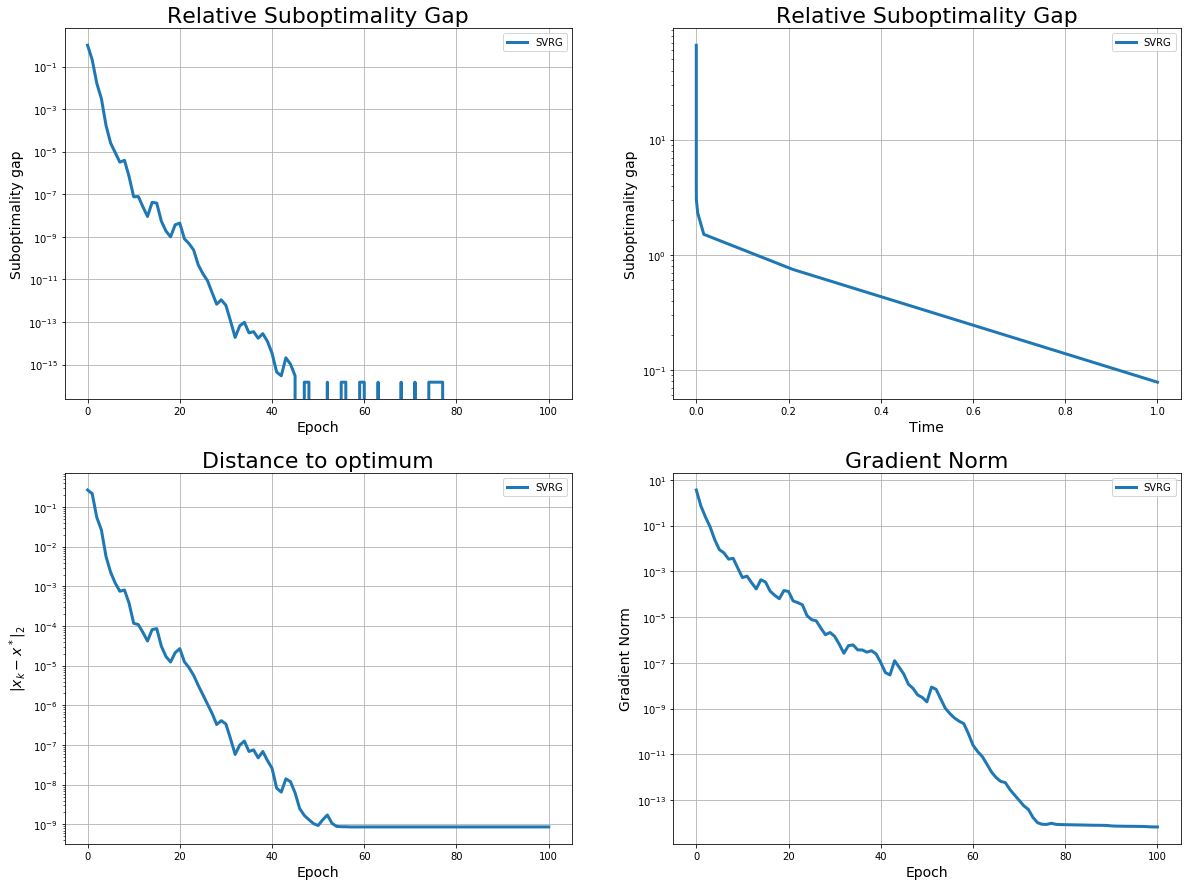

In [24]:
plt.figure(figsize=(20, 15))
algo = ["SVRG"] 

plt.subplot(2, 2, 1)
#for insp in inspectors:
plt.semilogy(svrg_robj_c, lw=3)
plt.grid()
plt.title("Relative Suboptimality Gap", fontsize=22)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Suboptimality gap", fontsize=14)
plt.legend(algo)

plt.subplot(2, 2, 2)
#for insp in inspectors:
plt.plot(svrg_robj_c, svrg_time_c, lw=3)
plt.yscale('log')
plt.grid()
plt.title("Relative Suboptimality Gap", fontsize=22)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Suboptimality gap", fontsize=14)
plt.legend(algo)

plt.subplot(2, 2, 3)
#for insp in inspectors:
plt.semilogy(svrg_err_c, lw=3)
plt.grid()
plt.title("Distance to optimum", fontsize=22)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
plt.legend(algo)

plt.subplot(2, 2, 4)
#for insp in inspectors:
plt.semilogy(svrg_grad_norm_c, lw=3)
plt.grid()
plt.title("Gradient Norm", fontsize=22)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Gradient Norm", fontsize=14)
plt.legend(algo);

### Numerical comparison

In [39]:
n = x_train_c.shape[0]
lbda = np.max(np.sum(x_train_c ** 2, axis=1))  / (4. * n)
model = Regression(x_train_c, y_train_c, lbda)

print("Min of the Loss %.2e" % f_min_c)
print("Time taken", svrg_time_c[100])
print("SVRG loss %.2e" % model.loss(svrg_theta_c))
print("SVRG gap %.2e" % svrg_robj_c[100])

Min of the Loss 3.19e-01
Time taken 66.3107640743
SVRG loss 9.16e-01
SVRG gap 0.00e+00



** Performance comparison : **

| Algorithm     | F_min         | Subopt Gap   | Running time |
| ------------- |--------------:| ------------:|-------------:|
| L-bfgs        |   3.19e-01    |      0       |      -       |
| SVRG          |   9.16e-01    |   0.00e+00   |    66.31     |
| SVRG2         | xxxx          |    xxxxx     |    xxxxx     |



<a id='comp2'></a>
## 5. Regression case : comparison


### Graphical Comparison

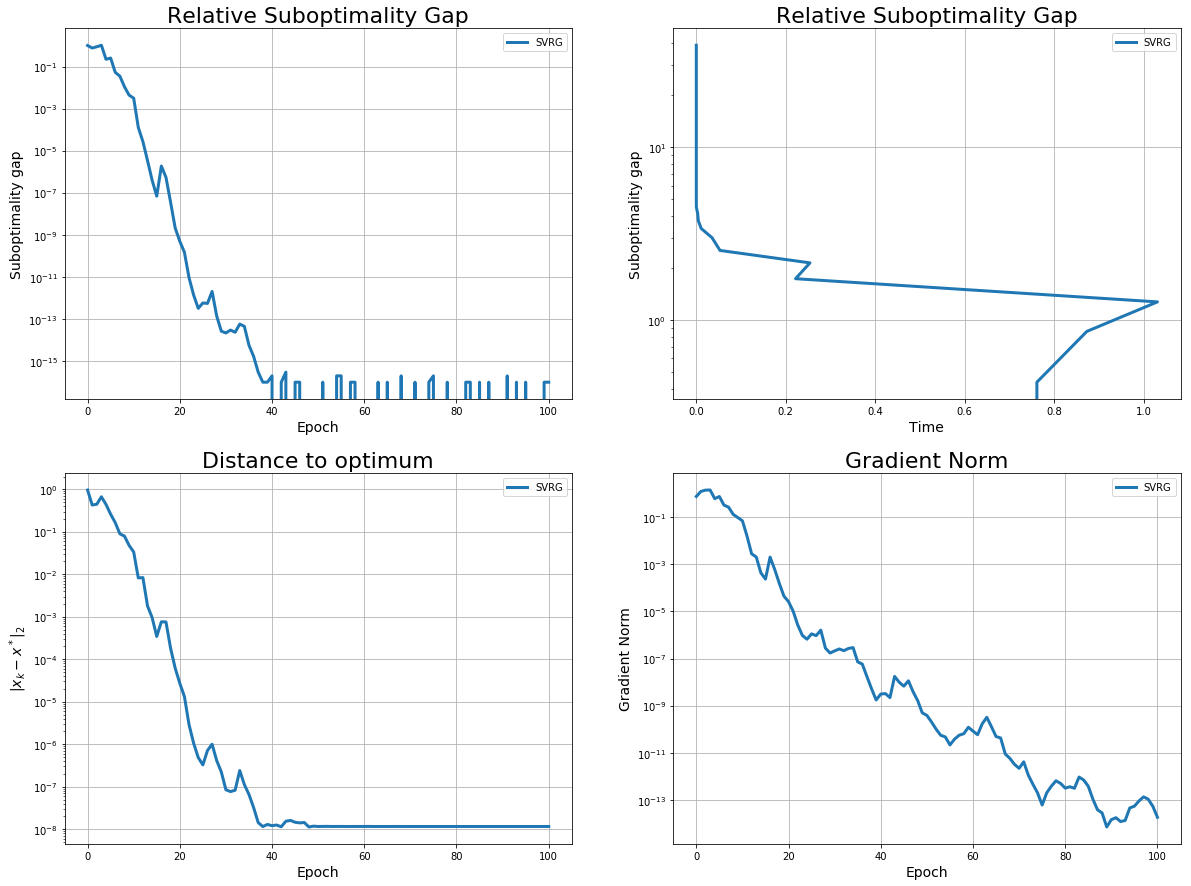

In [25]:
plt.figure(figsize=(20, 15))
algo = ["SVRG"] 

plt.subplot(2, 2, 1)
#for insp in inspectors:
plt.semilogy(svrg_robj_r, lw=3)
plt.grid()
plt.title("Relative Suboptimality Gap", fontsize=22)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Suboptimality gap", fontsize=14)
plt.legend(algo)

plt.subplot(2, 2, 2)
#for insp in inspectors:
plt.plot(svrg_robj_r, svrg_time_r, lw=3)
plt.yscale('log')
plt.grid()
plt.title("Relative Suboptimality Gap", fontsize=22)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Suboptimality gap", fontsize=14)
plt.legend(algo)

plt.subplot(2, 2, 3)
#for insp in inspectors:
plt.semilogy(svrg_err_r, lw=3)
plt.grid()
plt.title("Distance to optimum", fontsize=22)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
plt.legend(algo)

plt.subplot(2, 2, 4)
#for insp in inspectors:
plt.semilogy(svrg_grad_norm_r, lw=3)
plt.grid()
plt.title("Gradient Norm", fontsize=22)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Gradient Norm", fontsize=14)
plt.legend(algo);

### Numerical comparison

In [38]:
n = x_train_r.shape[0]
lbda = np.max(np.sum(x_train_r ** 2, axis=1)) / n
model = Regression(x_train_r, y_train_r, lbda)

print("Min of the Loss %.2e" % f_min_r)
print("Time taken", svrg_time_r[100])
print("SVRG loss %.2e" % model.loss(svrg_theta_r))
print("SVRG gap %.2e" % svrg_robj_r[100])

Min of the Loss 2.21e-01
Time taken 38.8588490486
SVRG loss 2.21e-01
SVRG gap 9.95e-17



** Performance comparison : **

| Algorithm     | F_min         | Subopt Gap   | Running time |
| ------------- |--------------:| ------------:|-------------:|
| L-bfgs        |   2.21e-01    |      0       |      -       |
| SVRG          |   2.21e-01    |   9.95e-17   |    38.86     |
| SVRG2         | xxxx          |    xxxxx     |    xxxxx     |

